# softmax回归的从0实现

In [1]:
import torch
from d2l import torch as d2l
from IPython import display

batch_size = 256
tran_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)

In [2]:
num_inputs = 784
num_outputs = 10

# torch.normal 用于生成服从正态分布（均值为0，标准差为0.01）的张量，而 torch.norm 是用于计算张量的范数
# 下面是用 normal 生成 W 的例子，size 应设置为 (num_inputs, num_outputs)
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

In [3]:
X = torch.tensor([[1.0,2.0,3.0],[4.0,5.0,6.0]])
X.sum(0,keepdim=True),X.sum(1,keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [5]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp/partition # 使用扩散

In [6]:
X = torch.normal(0,1,(2,5))
X_prob=softmax(X)
X_prob,X_prob.sum(1)

(tensor([[0.1106, 0.1048, 0.4649, 0.1997, 0.1201],
         [0.1785, 0.4070, 0.2258, 0.0707, 0.1180]]),
 tensor([1.0000, 1.0000]))

In [7]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W)+b)

In [8]:
y=torch.tensor([0,2])
y_hat=torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y_hat[range(2),y]

tensor([0.1000, 0.5000])

In [9]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)),y])

cross_entropy(y_hat=y_hat,y=y)

tensor([2.3026, 0.6931])

In [11]:
def accuracy(y_hat,y):
    # 如果y_hat是二维且每行代表一个类别概率分布，则通过argmax获得预测的类别
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat = y_hat.argmax(axis=1)
    # 比较预测类别和真实类别是否一致
    # .type把张量转换为给定的数据类型。这里y_hat.type(y.dtype)是把y_hat的类型转换成y一样的类型
    cmp = y_hat.type(y.dtype) == y
    # 统计预测正确的数量（用sum），并转换为浮点型
    return float(cmp.type(y.dtype).sum())

In [13]:
accuracy(y_hat=y_hat,y=y)/len(y)

0.5

In [14]:
# 这个函数用于评估给定网络net在数据集data_iter上的预测准确率
from d2l.torch import Accumulator

def evaluate_accuray(net, data_iter):
    # 如果网络是nn.Module的实例，则将其切换到评估模式
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)  # 累加器，第一个存准确预测数，第二个存总样本数
    with torch.no_grad():    # 在评估时关闭梯度计算，提高效率
        for X, y in data_iter:
            # net(X)得到预测结果，accuracy函数计算准确预测数，y.numel()是当前批次样本数
            metric.add(accuracy(net(X), y), y.numel())
    # 返回总体准确率：准确预测数/总样本数
    return metric[0] / metric[1]

In [15]:
evaluate_accuray(net, test_iter)

0.1236

In [16]:
def train_epoch_ch3(net, tran_iter, loss, updater):
    """训练循环"""
    # 训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和/准确度综合/样本数
    metric = Accumulator(3)
    for X,y in tran_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat=y_hat,y=y),y.numel())
    return metric[0]/metric[2],metric[1]/metric[2]

In [17]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [18]:
def train_ch3(net, tran_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel="epoch",xlim=[1,num_epochs],ylim=[0.3,0.9],legend=['train loss','train acc','test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, tran_iter, loss=loss, updater=updater)
        test_acc = evaluate_accuray(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc,))
    train_loss,train_acc = train_metrics
    # 下面的断言用于检查模型训练后的性能。
    # 第一个断言确保训练损失(train_loss)小于0.5，否则会抛出异常并显示损失值。
    assert train_loss < 0.5, train_loss
    # 第二个断言要求训练准确率(train_acc)介于0.7和1之间（不含0.7，含1），否则显示其准确率。
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    # 第三个断言要求测试准确率(test_acc)也介于0.7和1之间，否则显示其准确率。
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [19]:
def sgd(params, lr, batch_size):
    """"随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [20]:
lr = 0.1
def updater(batch_size):
    return sgd([W,b],lr,batch_size)

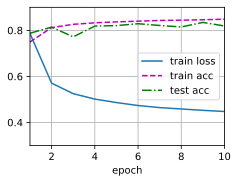

In [21]:
num_epochs= 10

train_ch3(net, tran_iter, test_iter, cross_entropy, num_epochs, updater)

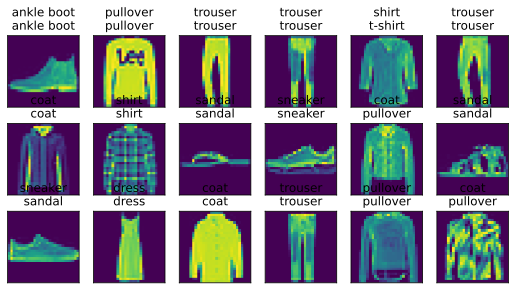

In [22]:
def predit_ch3(net, test_iter, n=6):
    # 这里用于从test_iter中获取一个批量的测试数据X和对应标签y
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    title = [trues + '\n' + pred for trues,pred in zip(trues,preds)]
    d2l.show_images(
        X[0:n].reshape((n,28,28)),3,6,titles=title[0:n]
    )
    
predit_ch3(net, test_iter,18)